In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 5.0 MB/s 


In [3]:
import mtcnn
import glob
from numpy import asarray
from PIL import Image
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
import pandas as pd
import numpy as np
import tensorflow as tf
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [4]:
dataset_images=glob.glob("gdrive/My Drive/facial_recog/dataset/*.jpg")
count=0
labels=[]
for i in dataset_images:
  count=count+1
  i=i.replace('gdrive/My Drive/facial_recog/dataset/','')
  i=i.replace('.jpg','')
  labels.append(i)
image_embeddings=np.load('gdrive/My Drive/facial_recog/img_embd.npy')
deep_network = load_model('gdrive/My Drive/facial_recog/facenet_keras.h5')
classifier = load_model('gdrive/My Drive/facial_recog/logisticClassifier.h5')
def getEmbd(trainX):
  embd=deep_network.predict(trainX)
  return embd
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# **RUNTIME**

<IPython.core.display.Javascript object>

Saved to photo.jpg


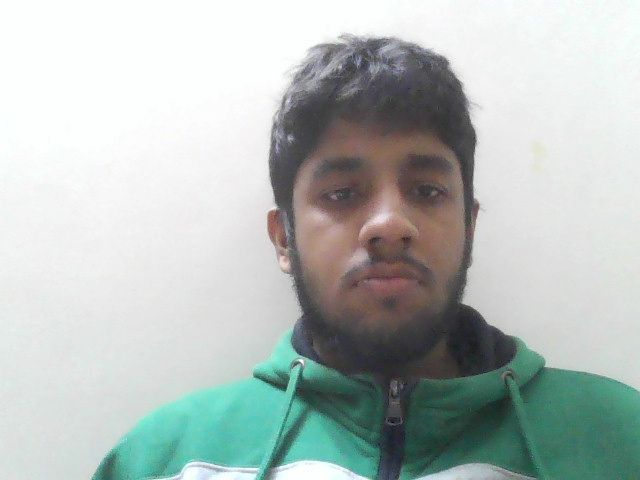

In [9]:
#@title
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [10]:
from PIL import Image
def extract_face(filename, required_size=(160, 160)):
	image = Image.open(filename)
	image = image.convert('RGB')
	pixels = asarray(image)
	detector = MTCNN()
	results = detector.detect_faces(pixels)
	x1, y1, width, height = results[0]['box']
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	face = pixels[y1:y2, x1:x2]
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
img=extract_face('photo.jpg')

In [11]:
#@title
from PIL import Image
def extract_face(filename, required_size=(160, 160)):
	image = Image.open(filename)
	image = image.convert('RGB')
	pixels = asarray(image)
	detector = MTCNN()
	results = detector.detect_faces(pixels)
	x1, y1, width, height = results[0]['box']
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	face = pixels[y1:y2, x1:x2]
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
img=extract_face('photo.jpg')
img=img.astype('float32')
mean=img.mean()
std=img.std()
img=(img-mean)/std
img_help=tf.expand_dims(img,axis=0)
img_embd=getEmbd(img_help)
img_embd2=[]
for i in range(count):
  img_embd2.append(img_embd[0])
img_embd2=np.array(img_embd2)
finalEmbd=img_embd2-image_embeddings
for i in range(count):
  for j in range(128):
    if (finalEmbd[i][j]<0):finalEmbd[i][j]=finalEmbd[i][j]*(-1)
outputs=classifier.predict(finalEmbd)
ans=0
for i in range (1,count):
  if(outputs[i]>outputs[ans]):
    ans=i

In [12]:
#@title
if(outputs[ans]<0.5):
  print("none")
else:
  print(labels[ans])

ashish
